## Package Import

In [24]:
import os 
import numpy as np 
import pandas as pd 
from scipy.sparse import csr_matrix

import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.optim import SGD

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import random
from matplotlib import pyplot as plt


## Data Preprocess

In [27]:
dpath = 'archive-2'
data_list = []
for i in os.listdir(dpath):
    if 'combined_data' in i:
        data_list.append(i)
data_list

['combined_data_1.txt',
 'combined_data_3.txt',
 'combined_data_2.txt',
 'combined_data_4.txt']

In [28]:
df = pd.DataFrame({'Cust_ID','Rating'}) 

for data in data_list:
    temp_df = pd.read_csv(os.path.join(dpath, data), header = None, names = ['Cust_ID', 'Rating'], usecols = [0,1])
    temp_df['Rating'] = temp_df['Rating'].astype(float)
    df = pd.concat([df, temp_df])
    print("Loaded: ", data)

df.index = np.arange(0,len(df))

Loaded:  combined_data_1.txt
Loaded:  combined_data_3.txt
Loaded:  combined_data_2.txt
Loaded:  combined_data_4.txt


In [29]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()
df_nan

,index,Rating
0,0,True
1,1,True
2,2,True
3,550,True
4,696,True
...,...,...
17767,100488433,True
17768,100489039,True
17769,100489244,True
17770,100490607,True


In [30]:
movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [3.0000e+00 3.0000e+00 3.0000e+00 ... 1.7772e+04 1.7772e+04 1.7772e+04]
Length: 100480507


In [34]:
df = df[pd.notnull(df['Rating'])]
df['Movie_Id'] = movie_np.astype(int)
df['Cust_ID'] = df['Cust_ID'].astype(int)
print(df.iloc[::5000000, :])

/tmp/ipykernel_19942/3989374729.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie_Id'] = movie_np.astype(int)


             0  Cust_ID  Rating  Movie_Id
3          NaN  1488844     3.0         3
5000998    NaN   501954     2.0       998
10001964   NaN   404654     5.0      1964
15002878   NaN   886608     2.0      2878
20003827   NaN  1193835     2.0      3827
25004724   NaN    35179     4.0      4724
30005670   NaN  2561536     3.0      5670
35006570   NaN   200362     4.0      6570
40007523   NaN   686629     4.0      7523
45008341   NaN  1494017     2.0      8341
50009228   NaN   437784     4.0      9228
55010054   NaN   788058     4.0     10054
60010826   NaN   433661     4.0     10826
65011672   NaN  2402781     4.0     11672
70012700   NaN   182620     4.0     12700
75013584   NaN   506044     4.0     13584
80014455   NaN   353605     2.0     14455
85015118   NaN   664606     3.0     15118
90016010   NaN  2213715     3.0     16010
95016881   NaN  1589401     5.0     16881
100017629  NaN  2314006     4.0     17629


/tmp/ipykernel_19942/3989374729.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cust_ID'] = df['Cust_ID'].astype(int)


In [25]:
df = df[['Cust_ID', 'Movie_Id', 'Rating']]

user2idx = {j:i for i,j in enumerate(df['Cust_ID'].unique())}
item2idx = {j:i for i,j in enumerate(df['Movie_Id'].unique())}
df['Cust_ID'] = df['Cust_ID'].map(user2idx)
df['Movie_Id'] = df['Movie_Id'].map(item2idx)
df

/tmp/ipykernel_20511/4115711675.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cust_ID'] = df['Cust_ID'].map(user2idx)
/tmp/ipykernel_20511/4115711675.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie_Id'] = df['Movie_Id'].map(item2idx)


,Cust_ID,Movie_Id,Rating
0,0,0,3.0
1,1,0,5.0
2,2,0,4.0
3,3,0,4.0
4,4,0,3.0
...,...,...,...
100480502,542,17769,4.0
100480503,29273,17769,3.0
100480504,29251,17769,1.0
100480505,22793,17769,4.0


In [26]:
df.to_csv('preprocessed_df.csv', index=False)

## MF

In [2]:
df = pd.read_csv('preprocessed_df.csv')

In [18]:
def predict(P, Q, mu, b_u, b_i, user, item):
    pred = mu + b_u[user] + b_i[item] + P[user, :].T.dot(Q[item, :])
    return pred

In [19]:
def sgd(P, Q, mu, b_u, b_i, samples, lr, reg):
    for user, item, rating in samples:
        pred = predict(P, Q, mu, b_u, b_i, user, item)
        
        error = rating - pred
        
        b_u[user] += lr * (error - reg * b_u[user])
        b_i[item] += lr * (error - reg * b_i[item])
        
        P[user, :] += lr * (error * Q[item, :] - reg * P[user, :])
        Q[item, :] += lr * (error * P[user, :] - reg * Q[item, :])

In [20]:
def rmse(samples, P, Q, mu, b_u, b_i):
    error = [] 
    for user,item,rating in samples:
        square_error = (rating - predict(P, Q, mu, b_u, b_i, user, item))**2
        error.append(square_error)
    rmse = np.sqrt(np.array(error).mean())
    return rmse

In [53]:
class MF_with_sgd(object):
    
    def __init__(self, df ,num_users, num_items, F, lr, reg, epochs):
        self.df = df
        self.num_users, self.num_items = num_users, num_items
        self.F = F
        self.lr = lr 
        self.reg = reg 
        self.epochs = epochs
        
        self.summary = pd.DataFrame(columns = ['epoch','rmse'])
        
    def build_samples(self): 
        
        self.samples = [] 
        self.users = self.df['Cust_ID'].values 
        self.items = self.df['Movie_Id'].values
        self.ratings = self.df['Rating'].values
        
        for idx in range(len(self.df)):
            if (idx % 10000000) == 0: 
                print(f"Loaded: {idx}th sample")
            self.samples.append((self.users[idx],self.items[idx],self.ratings[idx]))
    
    def train(self): 
        self.P = np.random.normal(scale = 1/self.F,size = (self.num_users, self.F))
        self.Q = np.random.normal(scale = 1/self.F,size = (self.num_items, self.F))
        
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        
        self.mu = self.df['Rating'].mean()
        
        self.samples = self.samples[:10000000]
        for epoch in range(self.epochs): 
            print(f"Start: {epoch}th epoch")
            np.random.shuffle(self.samples)
            sgd(self.P, self.Q, self.mu, self.b_u, self.b_i, self.samples, self.lr, self.reg)
            loss = rmse(self.samples, self.P, self.Q, self.mu, self.b_u, self.b_i)
            print(f"Epoch: {epoch} ; error = {loss}")
            self.summary.loc[epoch] = [epoch, loss]
            

In [54]:
K = 10 
lr = 0.01 
reg = 0.2 
epochs = 30 

user_num = df['Cust_ID'].nunique()
item_num = df['Movie_Id'].nunique()

mf = MF_with_sgd(df,user_num,item_num, K, lr, reg, epochs)
mf.build_samples()

Loaded: 0th sample
Loaded: 10000000th sample
Loaded: 20000000th sample
Loaded: 30000000th sample
Loaded: 40000000th sample
Loaded: 50000000th sample
Loaded: 60000000th sample
Loaded: 70000000th sample
Loaded: 80000000th sample
Loaded: 90000000th sample
Loaded: 100000000th sample


In [55]:
mf.train()

Start: 0th epoch
Epoch: 0 ; error = 0.9572316469694094
Start: 1th epoch
Epoch: 1 ; error = 0.9397509040615157
Start: 2th epoch
Epoch: 2 ; error = 0.9314324950641998
Start: 3th epoch
Epoch: 3 ; error = 0.9270099889285239
Start: 4th epoch
Epoch: 4 ; error = 0.9224233657054468
Start: 5th epoch
Epoch: 5 ; error = 0.9205277940045398
Start: 6th epoch
Epoch: 6 ; error = 0.9186038999752827
Start: 7th epoch
Epoch: 7 ; error = 0.9176232089183574
Start: 8th epoch
Epoch: 8 ; error = 0.9158445003121978
Start: 9th epoch
Epoch: 9 ; error = 0.9149430735985525
Start: 10th epoch
Epoch: 10 ; error = 0.9137905380706801
Start: 11th epoch
Epoch: 11 ; error = 0.913244668978982
Start: 12th epoch
Epoch: 12 ; error = 0.9128372666927342
Start: 13th epoch
Epoch: 13 ; error = 0.9126737849916143
Start: 14th epoch
Epoch: 14 ; error = 0.9121091712182122
Start: 15th epoch
Epoch: 15 ; error = 0.9110212450433007
Start: 16th epoch
Epoch: 16 ; error = 0.9110054170528965
Start: 17th epoch
Epoch: 17 ; error = 0.910586942905

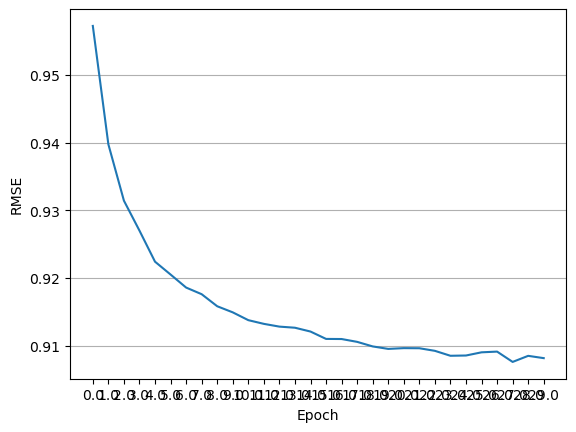

In [56]:
result_df = mf.summary 

x = result_df['epoch'].values
y = result_df['rmse'].values

plt.plot(x, y)
plt.xticks(x,x)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.grid(axis = 'y')
plt.show()

## ALS

In [154]:
def als(R, P, Q, F, reg):
    for user in range(R.shape[0]):
        QT_Q = np.matmul(Q.T, Q)
        li = reg * np.eye(F)
        QT_ru = np.matmul(Q.T,R[user].toarray()[0])
        P[user] = np.linalg.solve(QT_Q + li,QT_ru)
        
    for item in range(R.shape[1]):
        PT_P = np.matmul(P.T, P)
        li = reg * np.eye(F)
        PT_ri = np.matmul(P.T,R[:,item].toarray())
        Q[item] = np.linalg.solve(PT_P + li,PT_ri).reshape(-1)

In [155]:
def als_loss(sample, R, P, Q, reg):
    loss = 0
    for user, item, rating in sample: 
        loss += (rating - np.matmul(P[user],Q[item]))**2
    for user in range(R.shape[0]):
        loss += reg * np.matmul(P[user],P[user])
    for item in range(R.shape[1]):
        loss += reg * np.matmul(Q[item],Q[item])
        
    return loss

In [163]:
class MF_with_als(object):
    def __init__(self, df, R, F, reg, epochs):
        self.df = df
        self.R = R
        self.num_users, self.num_items = R.shape 
        self.F = F 
        self.reg = reg 
        self.epochs = epochs 
        
        self.summary = pd.DataFrame(columns = ['epoch','loss'])
    
    def build_samples(self):
        self.samples = []
        self.users = self.df['Cust_ID'].values
        self.items = self.df['Movie_Id'].values
        self.ratings = self.df['Rating'].values
        
        for idx in range(len(self.df)):
            if (idx % 10000000) == 0:
                print(f"Loaded: {idx}th sample")
            self.samples.append((self.users[idx],self.items[idx],self.ratings[idx]))
                
    def train(self):
        self.P = np.random.normal(scale = 1/self.F, size = (self.num_users, self.F))
        self.Q = np.random.normal(scale = 1/self.F, size = (self.num_items, self.F))
            
        for epoch in range(self.epochs): 
            print(f'Start: {epoch}th epoch')
            als(self.R, self.P, self.Q, self.F, self.reg)
            loss = als_loss(self.samples, self.R, self.P, self.Q, self.reg)
            print(f'Epoch: {epoch} ; loss = {loss}')
            self.summary.loc[epoch] = [epoch, loss]
            
    

In [161]:
als_df = df.iloc[:10000000]
als_df_user2idx = {user:idx for idx, user in enumerate(als_df['Cust_ID'].unique())}
als_df_item2idx = {item:idx for idx, item in enumerate(als_df['Movie_Id'].unique())}
als_df['Cust_ID'] = als_df['Cust_ID'].map(als_df_user2idx)
als_df['Movie_Id'] = als_df['Movie_Id'].map(als_df_item2idx)

/tmp/ipykernel_20511/902390691.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  als_df['Cust_ID'] = als_df['Cust_ID'].map(als_df_user2idx)
/tmp/ipykernel_20511/902390691.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  als_df['Movie_Id'] = als_df['Movie_Id'].map(als_df_item2idx)


In [162]:
R = csr_matrix(
    (np.array(als_df['Rating'].values, dtype = np.int32),
    (np.array(als_df['Cust_ID'].values, dtype = np.int32),np.array(als_df['Movie_Id'].values, dtype = np.int32))
    ))

F = 10 
reg = 0.2
epochs = 500 

In [164]:
MF_als = MF_with_als(als_df, R, F, reg, epochs)
MF_als.build_samples()

Loaded: 0th sample


In [ ]:
MF_als.train()

## Pytorch Implementation

### Training Setting

In [20]:
class Netflix(Dataset):
    def __init__(self, df):
        self.df = df
        self.users = self.df['Cust_ID'].values
        self.items = self.df['Movie_Id'].values
        self.ratings = self.df['Rating'].values
        
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        user = self.users[index]
        item = self.items[index]
        rating = self.ratings[index]
        
        return user, item, rating

In [25]:
sample_df = df.loc[df['Cust_ID'] < 5000]

train_df, test_df = train_test_split(sample_df, test_size = 0.2, random_state = 42)

In [17]:
train_dataset = Netflix(train_df)
test_dataset = Netflix(test_df)
train_dataloader = DataLoader(train_dataset, batch_size=10000, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10000, shuffle=True)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def train(model, train_loader, criterion ,optimizer):
    model.train() 
    total_loss = 0 
    for user, item, rating in train_loader:
        user = user.to(device)
        item = item.to(device)
        rating = rating.to(device)
        
        optimizer.zero_grad()
        pred = model(user, item)
        loss = criterion(pred, rating)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for user, item, rating in test_loader:
            user = user.to(device)
            item = item.to(device)
            rating = rating.to(device)

            pred = model(user, item)
            loss = criterion(pred, rating)

            total_loss += loss.item()
    
    return total_loss / len(test_loader)

In [27]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

### Models

In [30]:
class BasicFactorizaionModel(nn.Module):
    def __init__(self, num_users, num_items, F):
        
        super(BasicFactorizaionModel, self).__init__()
        self.P = nn.Embedding(num_users, F)
        self.Q = nn.Embedding(num_items, F)
        
        self.P.weight.data.normal_(0,1./F)
        self.Q.weight.data.normal_(0,1./F)
    
    def forward(self, user, item):
        P_u = self.P(user)
        Q_i = self.Q(item)
        
        rui = torch.sum(P_u * Q_i, dim = 1)
        
        return rui


In [32]:
class AddingBiases(BasicFactorizaionModel):
    def __init__(self, num_users, num_items, F, mu):
        
        super(AddingBiases, self).__init__(num_users, num_items, F)
        self.user_biases = nn.Embedding(num_users, 1)
        self.item_biases = nn.Embedding(num_items, 1)
        
        self.user_biases.weight.data.normal_(0,1./F)
        self.item_biases.weight.data.normal_(0,1./F)
        
        self.mu = mu
        
    def forward(self, user, item):
        P_u = self.P(user)
        Q_i = self.Q(item)
        
        bu = self.user_biases(user) 
        bi = self.item_biases(item)
        
        rui = self.mu + torch.squeeze(bu) + torch.squeeze(bi) + torch.sum(P_u * Q_i, dim = 1)
        
        return rui 

In [33]:
class AdditionalInputSources(AddingBiases):
    def __init__(self, num_users, num_items, F, mu, implicit_data):
        super(AdditionalInputSources, self).__init__(num_users, num_items, F, mu)
        self.implicit_data = implicit_data
        
        self.implicit_factors = nn.Embedding(num_items, F)
        self.implicit_factors.weight.data.normal_(0,1./F)
        
    def forward(self, user, item):
        P_u = self.P(user)
        Q_i = self.Q(item)
        
        bu = self.user_biases(user)
        bi = self.item_biases(item)
        
        sum_of_xi = torch.sum(self.implicit_factors(self.implicit_data[user]),dim = 0)
        norm = len(self.implicit_data[user]) ** -0.5
        
        rui = self.mu + torch.squeeze(bu) + torch.squeeze(bi) + torch.sum(Q_i * (P_u + (norm * sum_of_xi)), dim = 1)
        
        return rui
        

In [ ]:
# class TemporalDynamics(AdditionalInputSources):
#     def __init__(self, num_users, num_items, F, mu, implicit_data):
#         super(TemporalDynamics, self).__init__(num_users, num_items, F, mu, implicit_data)
        
#         self.temporal_user_factors = nn.Embedding(num_users, 1)
#         self.temporal_item_factors = nn.Embedding(num_items, 1)
#         self.temporal_user_
        
        
#     def forward(self, user, item, time_bin):
#         P_u = self.P(user)
#         Q_i = self.Q(item)
        
#         bu = self.user_biases(user)
#         bi = self.item_biases(item)
        
#         sum_of_xi = torch.sum(self.implicit_factors(self.implicit_data[user]),dim = 0)
#         norm = len(self.implicit_data[user]) ** -0.5
        
#         sum_of_ti = self.temporal_factors(time_bin)
        
#         rui = self.mu + torch.squeeze(bu) + torch.squeeze(bi) + torch.sum(Q_i * (P_u + (norm * sum_of_xi) + sum_of_ti), dim = 1)
        
#         return rui